# Convolutional autoencoder for image denoising

**Author:** Alidine Houssaine

**Date created:** 2025/12/02<br>
**Last modified:** 2025/12/02<br>
**Description:** How to train a deep convolutional autoencoder for image denoising. and Projet CNNs

## Introduction

This example demonstrates how to implement a deep convolutional autoencoder
for image denoising, mapping noisy digits images from the MNIST dataset to
clean digits images.  

## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from keras import layers
from keras.datasets import mnist
from keras.models import Model


def preprocess(array):
    """Normalizes the supplied array and reshapes it."""
    array = array.astype("float32") / 255.0
    array = np.reshape(array, (len(array), 28, 28, 1))
    return array


def noise(array):
    """Adds random noise to each image in the supplied array."""
    noise_factor = 0.4
    noisy_array = array + noise_factor * np.random.normal(
        loc=0.0, scale=1.0, size=array.shape
    )

    return np.clip(noisy_array, 0.0, 1.0)


def display(array1, array2):
    """Displays ten random images from each array."""
    n = 10
    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]
    images2 = array2[indices, :]

    plt.figure(figsize=(20, 4))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(image1.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(image2.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()


## Prepare the data

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


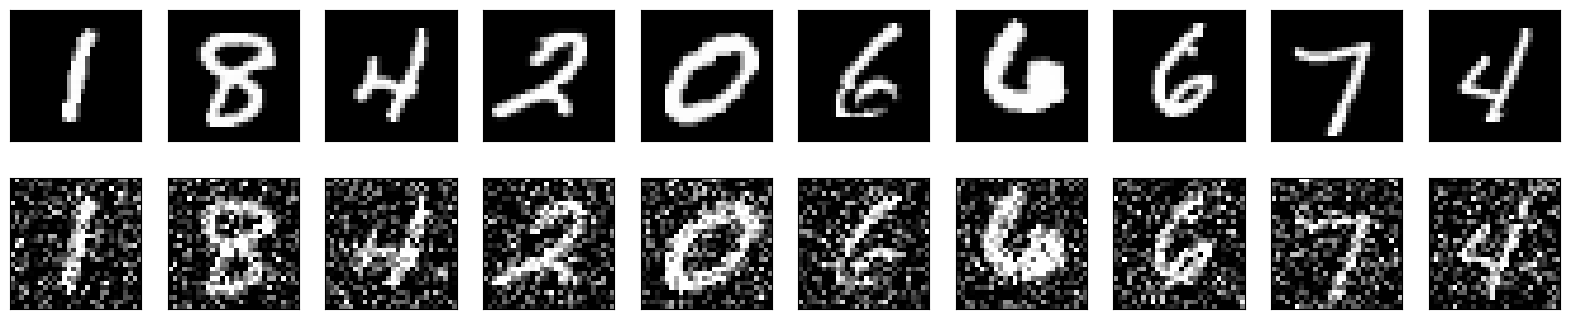

In [2]:
# Since we only need images from the dataset to encode and decode, we
# won't use the labels.
(train_data, _), (test_data, _) = mnist.load_data()

# Normalize and reshape the data
train_data = preprocess(train_data)
test_data = preprocess(test_data)

# Create a copy of the data with added noise
noisy_train_data = noise(train_data)
noisy_test_data = noise(test_data)

# Display the train data and a version of it with added noise
display(train_data, noisy_train_data)

## Build the autoencoder

We are going to use the Functional API to build our convolutional autoencoder.

In [3]:
input = layers.Input(shape=(28, 28, 1))

# Encoder
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)

# Decoder
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)

# Autoencoder
autoencoder = Model(input, x)
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")
autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 14, 14, 32)     │         9,248 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 28, 28, 32)     │         9,248 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,353 (110.75 KB)

 Trainable params: 28,353 (110.75 KB)

 Non-trainable params: 0 (0.00 B)

Now we can train our autoencoder using `train_data` as both our input data
and target. Notice we are setting up the validation data using the same
format.

In [4]:
autoencoder.fit(
    x=train_data,
    y=train_data,
    epochs=10,
    batch_size=128,
    shuffle=True,
    validation_data=(test_data, test_data),
)

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - loss: 0.2612 - val_loss: 0.0731
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0727 - val_loss: 0.0695
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0697 - val_loss: 0.0681
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0684 - val_loss: 0.0672
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0675 - val_loss: 0.0665
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0668 - val_loss: 0.0660
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0663 - val_loss: 0.0655
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0658 - val_loss: 0.0653
Epoch 9/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0656 - val_loss: 0.0650
Epoch 10/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0652 - val_loss: 0.0647


Let's predict on our test dataset and display the original image together with
the prediction from our autoencoder.

Notice how the predictions are pretty close to the original images, although
not quite the same.

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


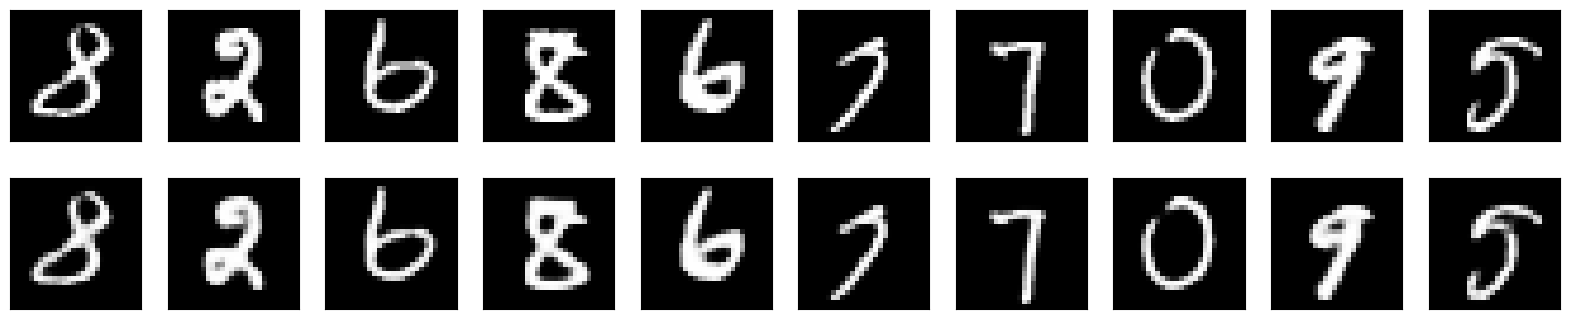

In [5]:
predictions = autoencoder.predict(test_data)
display(test_data, predictions)

Now that we know that our autoencoder works, let's retrain it using the noisy
data as our input and the clean data as our target. We want our autoencoder to
learn how to denoise the images.

In [7]:
autoencoder.fit(
    x=noisy_train_data,
    y=train_data,
    epochs=10,
    batch_size=128,
    shuffle=True,
    validation_data=(noisy_test_data, test_data),
)

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0869 - val_loss: 0.0861
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0866 - val_loss: 0.0859
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0864 - val_loss: 0.0859
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0864 - val_loss: 0.0862
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0861 - val_loss: 0.0855
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0859 - val_loss: 0.0854
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0861 - val_loss: 0.0853
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0858 - val_loss: 0.0852
Epoch 9/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0856 - val_loss: 0.0851
Epoch 10/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0856 - val_loss: 0.0851


Let's now predict on the noisy data and display the results of our autoencoder.

Notice how the autoencoder does an amazing job at removing the noise from the
input images.

In [8]:
predictions = autoencoder.predict(noisy_test_data)
display(noisy_test_data, predictions)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


#Classification des images à partir de zéro

##Description:

Entraîner un classificateur d’images à partir de zéro sur le jeu de données Kaggle Cats vs Dogs

##Introduction:
Cet exemple montre comment faire une classification d’image de zéro, en partant du JPEG fichiers image sur disque, sans utiliser de poids pré-entraînés ni de Keras pré-fabriqué Modèle d’application. Nous démontrons le flux de travail sur le binaire Kaggle Cats vs Dogs Jeu de données de classification.

Nous utilisons l’utilitaire image_dataset_from_directory pour générer les ensembles de données, et nous utilisons les couches de prétraitement d’image Keras pour la standardisation et l’augmentation des données.

In [2]:
import os
import numpy as np
import keras
from keras import layers
from tensorflow import data as tf_data
import matplotlib.pyplot as plt

Chargez les données : le jeu de données Cats vs Dogs

Tout d’abord, téléchargeons l’archive ZIP 786M des données brutes :

In [3]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0   107M      0  0:00:07  0:00:07 --:--:--  111M


In [4]:
!unzip -q kagglecatsanddogs_5340.zip
!ls


 CDLA-Permissive-2.0.pdf      PetImages        sample_data
 kagglecatsanddogs_5340.zip  'readme[1].txt'


Nous avons maintenant un dossier PetImages qui contient deux sous-dossiers, Cat et Dog. Chaque Sous-dossier contient des fichiers image pour chaque catégorie.

In [5]:
!ls PetImages

Cat  Dog


##Filtrer les images corrompues

Lorsqu’on travaille avec beaucoup de données d’images réelles, les images corrompues sont courantes occurrence. Filtrons les images mal codées qui ne comportent pas la chaîne « JFIF » dans leur en-tête.

In [6]:
num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = b"JFIF" in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print(f"Deleted {num_skipped} images.")

Deleted 1590 images.


##Générer un Dataset

In [7]:
image_size = (180, 180)
batch_size = 128

train_ds, val_ds = keras.utils.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Using 4682 files for validation.


##Visualisez les données

Voici les 9 premières images du jeu de données d’entraînement.

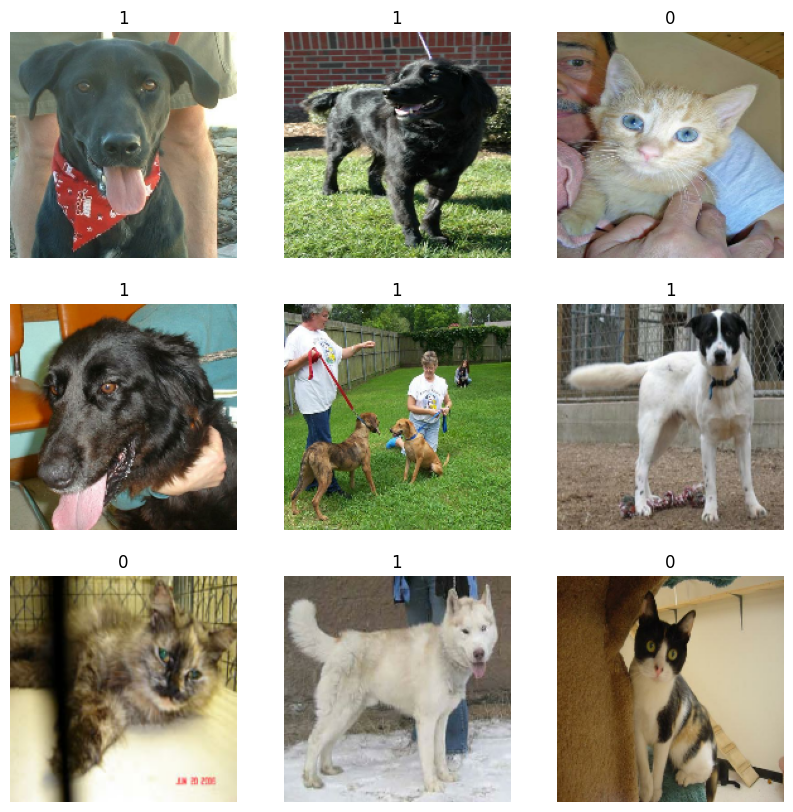

In [8]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

##Utilisation de l’augmentation des données d’image
Quand on n’a pas un grand jeu de données d’images, il est judicieux de le faire artificiellement introduire la diversité des échantillons en appliquant des transformations aléatoires mais réalistes à la des images d’entraînement, telles que des basculements horizontaux aléatoires ou de petites rotations aléatoires. Ceci Permet d’exposer le modèle à différents aspects des données d’entraînement tout en ralentissant Un sur-équipement.

In [9]:
data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]


def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images

Visualisons à quoi ressemblent les échantillons augmentés, en appliquant data_augmentation À plusieurs reprises aux premières images de l’ensemble de données :

In [10]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[0]).astype("uint8"))
        plt.axis("off")

##Standardisation des données
Nos images sont déjà à une taille standard (180x180), car elles sont produites comme float32 lots contigus par notre jeu de données. Cependant, leurs valeurs de canal RGB sont dans la plage [0, 255] Ce n’est pas idéal pour un réseau de neurones ; En général, vous devriez chercher à rendre vos valeurs d’entrée petites. Ici, nous le ferons standardisez les valeurs pour qu’elles appartiennent à [0, 1] en utilisant une Rescaling au début de notre modèle.

##Deux options pour prétraiter les données

Il y a deux façons d’utiliser le data_augmentation :

Option 1 : Intégrez-la au modèle, comme ceci :



In [11]:
input_shape = image_size + (3,)
inputs = keras.Input(shape=input_shape)
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
# ...  # Rest of the model

Avec cette option, votre augmentation de données se fera sur l’appareil, de manière synchrone avec le reste de l’exécution du modèle, ce qui signifie qu’il bénéficiera du GPU accélération.

Notez que l’augmentation des données est inactive au moment du test, donc les échantillons d’entrée ne seront que augmentée pendant fit() et non lors de l’appel evaluate() ou predict().

Si vous vous entraînez sur GPU, cela peut être une bonne option.

Option 2 : l’appliquer à l’ensemble de données, afin d’obtenir un ensemble de données qui donne des lots de Images augmentées, comme celle-ci :

In [12]:
augmented_train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))

Avec cette option, votre augmentation de données se fera sur le CPU, de manière asynchrone, et Soyez en mémoire tampon avant d’entrer dans le modèle.

Si vous vous entraînez sur CPU, c’est la meilleure option, car cela permet l’augmentation de données asynchrones et non bloquants.

Dans notre cas, nous opterons pour la deuxième option. Si tu n’es pas sûr Lequel choisir, cette seconde option (prétraitement asynchrone) est toujours un choix solide.

##Configurez le jeu de données pour les performances

Appliquons l’augmentation des données à notre jeu de données d’entraînement, Et assurons-nous d’utiliser un préchargement en mémoire tampon afin de pouvoir obtenir des données depuis le disque sans avoir l’I/O devenant blocant :

In [13]:
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf_data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
val_ds = val_ds.prefetch(tf_data.AUTOTUNE)

##Construire un modèle
Nous allons construire une petite version du réseau Xception. Nous n’avons pas vraiment essayé de optimiser l’architecture ; Si vous souhaitez effectuer une recherche systématique du meilleur modèle À considérer avec KerasTuner.

Notez que :

Nous commençons le modèle avec le data_augmentation, suivi d’un Rescaling de la couche.
Nous incluons une Dropout avant la couche finale de classification.

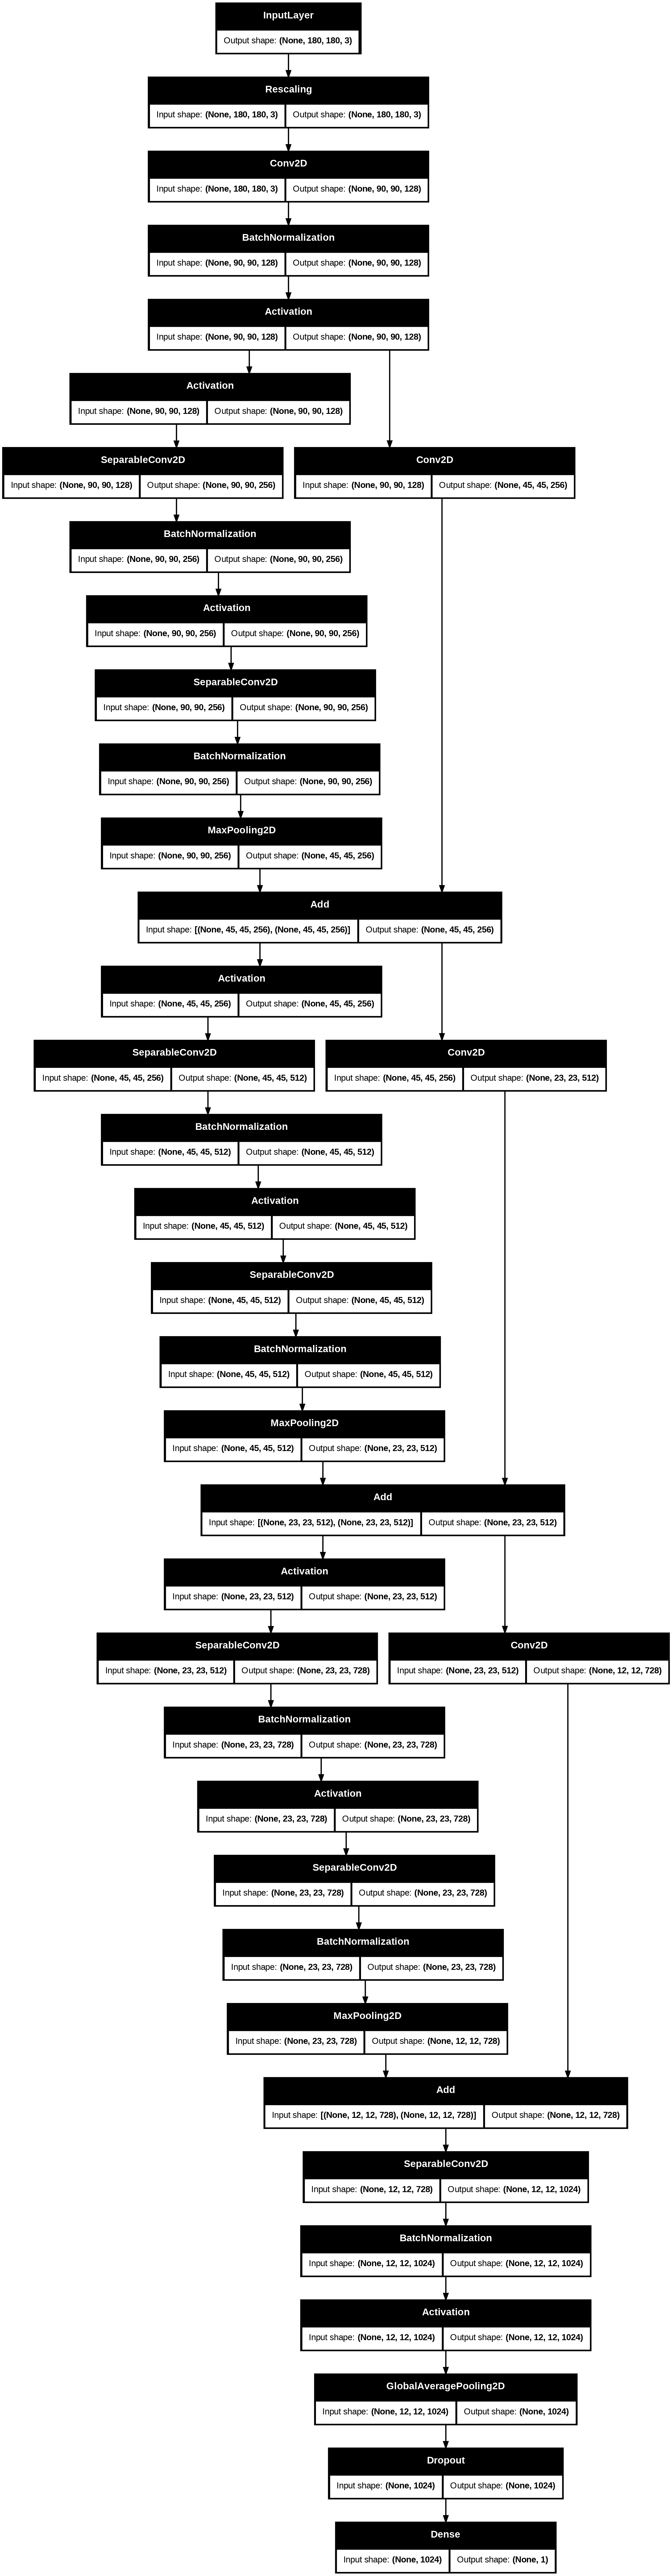

In [14]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        units = 1
    else:
        units = num_classes

    x = layers.Dropout(0.25)(x)
    # We specify activation=None so as to return logits
    outputs = layers.Dense(units, activation=None)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

##Entraînez le modèle

In [1]:
epochs = 5

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy(name="acc")],
)
model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

NameError: name 'keras' is not defined

Nous atteignons une précision de validation de >90 % après un entraînement de 25 époques sur l’ensemble complet du jeu de données (En pratique, on peut s’entraîner pendant 50+ époques avant que les performances de validation ne commencent à se dégrader).

##Exécuter l’inférence sur de nouvelles données
Notez que l’augmentation et la déchute des données sont inactives au moment de l’inférence.

In [ ]:
img = keras.utils.load_img("PetImages/Cat/6779.jpg", target_size=image_size)
plt.imshow(img)

img_array = keras.utils.img_to_array(img)
img_array = keras.ops.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = float(keras.ops.sigmoid(predictions[0][0]))
print(f"This image is {100 * (1 - score):.2f}% cat and {100 * score:.2f}% dog.")

#Estimation de la taille d’échantillon requise pour l’entraînement des modèles

description: Modéliser la relation entre la taille de l’ensemble d’entraînement et la précision du modèle.

##Introduction
Dans de nombreux scénarios réels, la quantité de données d’images disponibles pour entraîner un modèle d’apprentissage profond est limité. C’est particulièrement vrai dans le domaine de l’imagerie médicale, où la création de jeux de données est faite coûteux. L’une des premières questions qui se pose généralement lorsqu’on aborde un nouveau problème est : « Combien d’images aurons-nous besoin pour entraîner un modèle d’apprentissage automatique suffisamment bon ? »

Dans la plupart des cas, un petit ensemble d’échantillons est disponible, et nous pouvons l’utiliser pour modéliser la relation entre la taille des données d’entraînement et la performance du modèle. Un tel modèle peut être utilisé pour estimer l’optimale nombre d’images nécessaires pour atteindre une taille d’échantillon permettant d’atteindre la performance requise du modèle.

Une revue systématique de Méthodologies de détermination de la taille de l’échantillon par Balki et al. fournissent des exemples de plusieurs méthodes de détermination de la taille de l’échantillon. Dans ce Par exemple, un schéma de sous-échantillonnage équilibré est utilisé pour déterminer la taille d’échantillon optimale pour notre modèle. Cela se fait en sélectionnant un sous-échantillon aléatoire composé de Y nombre d’images et entraînant le modèle à l’aide du sous-échantillon. Le modèle est ensuite évalué sur un modèle indépendant Set de test. Ce processus est répété N fois pour chaque sous-échantillon avec un remplacement afin de permettre pour la construction d’une moyenne et d’un intervalle de confiance pour la performance observée.

Importation les biblitheque

In [15]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import keras
from keras import layers
import tensorflow_datasets as tfds

# Define seed and fixed variables
seed = 42
keras.utils.set_random_seed(seed)
AUTO = tf.data.AUTOTUNE

##Charger l'ensemble de données TensorFlow et convertir en tableaux NumPy
Nous utiliserons l'ensemble de données TF Flowers.

In [16]:
# Specify dataset parameters
dataset_name = "tf_flowers"
batch_size = 64
image_size = (224, 224)

# Load data from tfds and split 10% off for a test set
(train_data, test_data), ds_info = tfds.load(
    dataset_name,
    split=["train[:90%]", "train[90%:]"],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

# Extract number of classes and list of class names
num_classes = ds_info.features["label"].num_classes
class_names = ds_info.features["label"].names

print(f"Number of classes: {num_classes}")
print(f"Class names: {class_names}")


# Convert datasets to NumPy arrays
def dataset_to_array(dataset, image_size, num_classes):
    images, labels = [], []
    for img, lab in dataset.as_numpy_iterator():
        images.append(tf.image.resize(img, image_size).numpy())
        labels.append(tf.one_hot(lab, num_classes))
    return np.array(images), np.array(labels)


img_train, label_train = dataset_to_array(train_data, image_size, num_classes)
img_test, label_test = dataset_to_array(test_data, image_size, num_classes)

num_train_samples = len(img_train)
print(f"Number of training samples: {num_train_samples}")

Number of classes: 5
Class names: ['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']
Number of training samples: 3303


##Tracez quelques exemples de l'ensemble de test

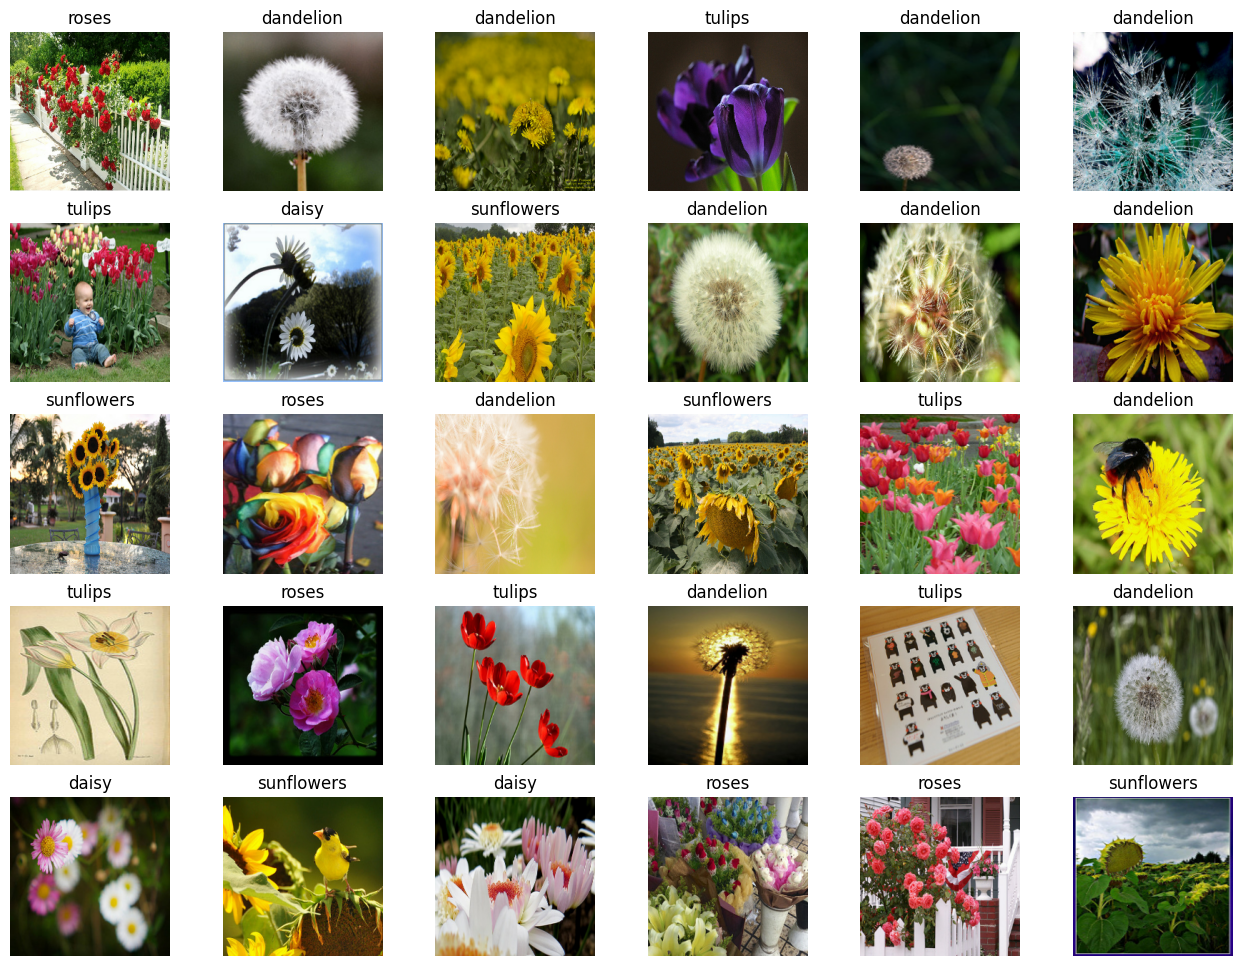

In [17]:
plt.figure(figsize=(16, 12))
for n in range(30):
    ax = plt.subplot(5, 6, n + 1)
    plt.imshow(img_test[n].astype("uint8"))
    plt.title(np.array(class_names)[label_test[n] == True][0])
    plt.axis("off")

##Augmentation
Définissez l'augmentation de l'image à l'aide des couches de prétraitement Keras et appliquez-les à l'ensemble d'entraînement.

In [ ]:
 # Define image augmentation model
image_augmentation = keras.Sequential(
    [
        layers.RandomFlip(mode="horizontal"),
        layers.RandomRotation(factor=0.1),
        layers.RandomZoom(height_factor=(-0.1, -0)),
        layers.RandomContrast(factor=0.1),
    ],
)

# Apply the augmentations to the training images and plot a few examples
img_train = image_augmentation(img_train).numpy()

plt.figure(figsize=(16, 12))
for n in range(30):
    ax = plt.subplot(5, 6, n + 1)
    plt.imshow(img_train[n].astype("uint8"))
    plt.title(np.array(class_names)[label_train[n] == True][0])
    plt.axis("off")

##Définir les fonctions de création de modèles et de formation
Nous créons quelques fonctions pratiques pour construire un modèle d'apprentissage par transfert, compiler et entraînez-le et dégelez les couches pour un réglage précis.

In [1]:
  def build_model(num_classes, img_size=image_size[0], top_dropout=0.3):
    """Creates a classifier based on pre-trained MobileNetV2.

    Arguments:
        num_classes: Int, number of classese to use in the softmax layer.
        img_size: Int, square size of input images (defaults is 224).
        top_dropout: Int, value for dropout layer (defaults is 0.3).

    Returns:
        Uncompiled Keras model.
    """

    # Create input and pre-processing layers for MobileNetV2
    inputs = layers.Input(shape=(img_size, img_size, 3))
    x = layers.Rescaling(scale=1.0 / 127.5, offset=-1)(inputs)
    model = keras.applications.MobileNetV2(
        include_top=False, weights="imagenet", input_tensor=x
    )

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.Dropout(top_dropout)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    model = keras.Model(inputs, outputs)

    print("Trainable weights:", len(model.trainable_weights))
    print("Non_trainable weights:", len(model.non_trainable_weights))
    return model


def compile_and_train(
    model,
    training_data,
    training_labels,
    metrics=[keras.metrics.AUC(name="auc"), "acc"],
    optimizer=keras.optimizers.Adam(),
    patience=5,
    epochs=5,
):
    """Compiles and trains the model.

    Arguments:
        model: Uncompiled Keras model.
        training_data: NumPy Array, training data.
        training_labels: NumPy Array, training labels.
        metrics: Keras/TF metrics, requires at least 'auc' metric (default is
                `[keras.metrics.AUC(name='auc'), 'acc']`).
        optimizer: Keras/TF optimizer (defaults is `keras.optimizers.Adam()).
        patience: Int, epochsfor EarlyStopping patience (defaults is 5).
        epochs: Int, number of epochs to train (default is 5).

    Returns:
        Training history for trained Keras model.
    """

    stopper = keras.callbacks.EarlyStopping(
        monitor="val_auc",
        mode="max",
        min_delta=0,
        patience=patience,
        verbose=1,
        restore_best_weights=True,
    )

    model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=metrics)

    history = model.fit(
        x=training_data,
        y=training_labels,
        batch_size=batch_size,
        epochs=epochs,
        validation_split=0.1,
        callbacks=[stopper],
    )
    return history


def unfreeze(model, block_name, verbose=0):
    """Unfreezes Keras model layers.

    Arguments:
        model: Keras model.
        block_name: Str, layer name for example block_name = 'block4'.
                    Checks if supplied string is in the layer name.
        verbose: Int, 0 means silent, 1 prints out layers trainability status.

    Returns:
        Keras model with all layers after (and including) the specified
        block_name to trainable, excluding BatchNormalization layers.
    """

    # Unfreeze from block_name onwards
    set_trainable = False

    for layer in model.layers:
        if block_name in layer.name:
            set_trainable = True
        if set_trainable and not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True
            if verbose == 1:
                print(layer.name, "trainable")
        else:
            if verbose == 1:
                print(layer.name, "NOT trainable")
    print("Trainable weights:", len(model.trainable_weights))
    print("Non-trainable weights:", len(model.non_trainable_weights))
    return model

##Définir la fonction de formation itérative
Pour entraîner un modèle sur plusieurs ensembles de sous-échantillons, nous devons créer une fonction de formation itérative.

In [6]:
def train_model(training_data, training_labels):
    """Trains the model as follows:

    - Trains only the top layers for 10 epochs.
    - Unfreezes deeper layers.
    - Train for 20 more epochs.

    Arguments:
        training_data: NumPy Array, training data.
        training_labels: NumPy Array, training labels.

    Returns:
        Model accuracy.
    """

    model = build_model(num_classes)

    # Compile and train top layers
    history = compile_and_train(
        model,
        training_data,
        training_labels,
        metrics=[keras.metrics.AUC(name="auc"), "acc"],
        optimizer=keras.optimizers.Adam(),
        patience=3,
        epochs=10,
    )

    # Unfreeze model from block 10 onwards
    model = unfreeze(model, "block_10")

    # Compile and train for 20 epochs with a lower learning rate
    fine_tune_epochs = 20
    total_epochs = history.epoch[-1] + fine_tune_epochs

    history_fine = compile_and_train(
        model,
        training_data,
        training_labels,
        metrics=[keras.metrics.AUC(name="auc"), "acc"],
        optimizer=keras.optimizers.Adam(learning_rate=1e-4),
        patience=5,
        epochs=total_epochs,
    )

    # Calculate model accuracy on the test set
    _, _, acc = model.evaluate(img_test, label_test)
    return np.round(acc, 4)

##Entraîner des modèles de manière itérative
Maintenant que nous disposons de fonctions de création de modèles et de fonctions itératives de support, nous pouvons former le modèle sur plusieurs divisions de sous-échantillons.

Nous sélectionnons les divisions de sous-échantillons à 5 %, 10 %, 25 % et 50 % de l'ensemble de données téléchargé. Nous prétendre que seulement 50 % des données réelles sont disponibles à l’heure actuelle.

Nous entraînons le modèle 5 fois à partir de zéro à chaque division et enregistrons les valeurs de précision.

Notez que cela entraîne 20 modèles et prendra un certain temps. Assurez-vous d'avoir un environnement d'exécution GPU actif.

Pour que cet exemple reste léger, des exemples de données d'une exécution d'entraînement précédente sont fournis.

In [7]:
def train_iteratively(sample_splits=[0.05, 0.1, 0.25, 0.5], iter_per_split=5):
    """Trains a model iteratively over several sample splits.

    Arguments:
        sample_splits: List/NumPy array, contains fractions of the trainins set
                        to train over.
        iter_per_split: Int, number of times to train a model per sample split.

    Returns:
        Training accuracy for all splits and iterations and the number of samples
        used for training at each split.
    """
    # Train all the sample models and calculate accuracy
    train_acc = []
    sample_sizes = []

    for fraction in sample_splits:
        print(f"Fraction split: {fraction}")
        # Repeat training 3 times for each sample size
        sample_accuracy = []
        num_samples = int(num_train_samples * fraction)
        for i in range(iter_per_split):
            print(f"Run {i+1} out of {iter_per_split}:")
            # Create fractional subsets
            rand_idx = np.random.randint(num_train_samples, size=num_samples)
            train_img_subset = img_train[rand_idx, :]
            train_label_subset = label_train[rand_idx, :]
            # Train model and calculate accuracy
            accuracy = train_model(train_img_subset, train_label_subset)
            print(f"Accuracy: {accuracy}")
            sample_accuracy.append(accuracy)
        train_acc.append(sample_accuracy)
        sample_sizes.append(num_samples)
    return train_acc, sample_sizes


# Running the above function produces the following outputs
train_acc = [
    [0.8202, 0.7466, 0.8011, 0.8447, 0.8229],
    [0.861, 0.8774, 0.8501, 0.8937, 0.891],
    [0.891, 0.9237, 0.8856, 0.9101, 0.891],
    [0.8937, 0.9373, 0.9128, 0.8719, 0.9128],
]

sample_sizes = [165, 330, 825, 1651]

##Courbe d'apprentissage
Nous traçons maintenant la courbe d'apprentissage en ajustant une courbe exponentielle passant par la précision moyenne points. Nous utilisons TF pour ajuster une fonction exponentielle à travers les données.

Nous extrapolons ensuite la courbe d'apprentissage pour prédire la précision d'un modèle formé sur l'ensemble de la formation.

In [1]:
 def fit_and_predict(train_acc, sample_sizes, pred_sample_size):
    """Fits a learning curve to model training accuracy results.

    Arguments:
        train_acc: List/Numpy Array, training accuracy for all model
                    training splits and iterations.
        sample_sizes: List/Numpy array, number of samples used for training at
                    each split.
        pred_sample_size: Int, sample size to predict model accuracy based on
                        fitted learning curve.
    """
    x = sample_sizes
    mean_acc = tf.convert_to_tensor([np.mean(i) for i in train_acc])
    error = [np.std(i) for i in train_acc]

    # Define mean squared error cost and exponential curve fit functions
    mse = keras.losses.MeanSquaredError()

    def exp_func(x, a, b):
        return a * x**b

    # Define variables, learning rate and number of epochs for fitting with TF
    a = tf.Variable(0.0)
    b = tf.Variable(0.0)
    learning_rate = 0.01
    training_epochs = 5000

    # Fit the exponential function to the data
    for epoch in range(training_epochs):
        with tf.GradientTape() as tape:
            y_pred = exp_func(x, a, b)
            cost_function = mse(y_pred, mean_acc)
        # Get gradients and compute adjusted weights
        gradients = tape.gradient(cost_function, [a, b])
        a.assign_sub(gradients[0] * learning_rate)
        b.assign_sub(gradients[1] * learning_rate)
    print(f"Curve fit weights: a = {a.numpy()} and b = {b.numpy()}.")

    # We can now estimate the accuracy for pred_sample_size
    max_acc = exp_func(pred_sample_size, a, b).numpy()

    # Print predicted x value and append to plot values
    print(f"A model accuracy of {max_acc} is predicted for {pred_sample_size} samples.")
    x_cont = np.linspace(x[0], pred_sample_size, 100)

    # Build the plot
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.errorbar(x, mean_acc, yerr=error, fmt="o", label="Mean acc & std dev.")
    ax.plot(x_cont, exp_func(x_cont, a, b), "r-", label="Fitted exponential curve.")
    ax.set_ylabel("Model classification accuracy.", fontsize=12)
    ax.set_xlabel("Training sample size.", fontsize=12)
    ax.set_xticks(np.append(x, pred_sample_size))
    ax.set_yticks(np.append(mean_acc, max_acc))
    ax.set_xticklabels(list(np.append(x, pred_sample_size)), rotation=90, fontsize=10)
    ax.yaxis.set_tick_params(labelsize=10)
    ax.set_title("Learning curve: model accuracy vs sample size.", fontsize=14)
    ax.legend(loc=(0.75, 0.75), fontsize=10)
    ax.xaxis.grid(True)
    ax.yaxis.grid(True)
    plt.tight_layout()
    plt.show()

    # The mean absolute error (MAE) is calculated for curve fit to see how well
    # it fits the data. The lower the error the better the fit.
    mae = keras.losses.MeanAbsoluteError()
    print(f"The mae for the curve fit is {mae(mean_acc, exp_func(x, a, b)).numpy()}.")


# We use the whole training set to predict the model accuracy
fit_and_predict(train_acc, sample_sizes, pred_sample_size=num_train_samples)

À partir de la courbe extrapolée, nous pouvons voir que 3 303 images donneront une estimation précision d'environ 95%.

Maintenant, utilisons toutes les données (3303 images) et entraînons le modèle pour voir si notre prédiction était précis !

In [1]:
 # Now train the model with full dataset to get the actual accuracy
accuracy = train_model(img_train, label_train)
print(f"A model accuracy of {accuracy} is reached on {num_train_samples} images!")

##Conclusion
Nous constatons qu’une précision du modèle d’environ 94 à 96 %* est atteinte en utilisant 3 303 images. C'est tout à fait proche de notre estimation !

Même si nous n'avons utilisé que 50 % de l'ensemble de données (1 651 images), nous avons pu modéliser la formation. comportement de notre modèle et prédire la précision du modèle pour une quantité donnée d’images. Ce même la méthodologie peut être utilisée pour prédire la quantité d’images nécessaires pour atteindre la précision souhaitée. Ceci est très utile lorsqu’un ensemble de données plus petit est disponible, et il a été démontré que la convergence sur un modèle d’apprentissage profond est possible, mais davantage d’images sont nécessaires. Le nombre d'images la prédiction peut être utilisée pour planifier et budgétiser d’autres initiatives de collecte d’images.